# SALES FORECASTING

***

# Importing Libraries

In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as stats
from scipy.stats import pearsonr
import itertools
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

# Loading Data

In [3]:
train_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
test_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
oil_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
transaction_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')
stores_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
holiday_event_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')

## Let's understand the data

### train.csv

In [4]:
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


>**store_nbr** is the unique store number.
>**family** suggests the type of product sold.

*rest details are self explainatory.*

### test.csv

In [5]:
test_df.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


### oil.csv

In [6]:
oil_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


>* The data tells about oil prices during the train and test set timeframes.
>* This will be useful un understanding economic impacts on the sales.

### stores.csv

In [7]:
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


>* This is metadata about stores.
>* Data tells about a store's city, state, type and cluster (grouping of similar stores).

### transactions.csv

In [8]:
transaction_df.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [9]:
transaction_df['store_nbr'].value_counts().head()

store_nbr
39    1678
38    1678
26    1678
31    1678
33    1678
Name: count, dtype: int64

> Above code tells that these are not unique transactions, but transactions happening in a day for a particular store.

### holidays_events.csv

In [10]:
holiday_event_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


## Combining the data

### Let's first add store information to the store data ...

In [11]:
# since, we dont want to miss on any training data, let's go with left join.
### inner can also work, but if some id are missing in metadata, then the info is gone.

train_merge_1 = pd.merge(train_df, stores_df, on='store_nbr', how='left')

# a check on if data is intact or not
print(train_df.shape, train_merge_1.shape)

(3000888, 6) (3000888, 10)


> The merge operation added 4 columns. These are the columns from the stores metadata. Makes sense!

In [12]:
train_merge_1.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13


### Adding oil price data to dataset ...

In [13]:
train_merge_1['date'] = pd.to_datetime(train_merge_1['date'])
oil_df['date'] = pd.to_datetime(oil_df['date'])

# Merge on 'date'
train_merge_2 = pd.merge(train_merge_1, oil_df, on='date', how='left')

# checking on if all data is taken care
print(train_merge_1.shape, train_merge_2.shape)

(3000888, 10) (3000888, 11)


In [14]:
train_merge_2.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN


### Adding holiday info now ...

In [15]:
train_merge_2['date'] = pd.to_datetime(train_merge_2['date'])
holiday_event_df['date'] = pd.to_datetime(holiday_event_df['date'])

holiday_event_df = holiday_event_df.rename(columns={'type': 'holiday_type'})

# Merge on 'date'
train_merge = pd.merge(train_merge_2, holiday_event_df, 
                         on='date', how='left')

# checking on if all data is taken care
print(train_merge_2.shape, train_merge.shape)

(3000888, 11) (3054348, 16)


In [16]:
train_merge.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,holiday_type,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False


## Some checks on the dataset

In [17]:
train_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 16 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   int64         
 6   city          object        
 7   state         object        
 8   type          object        
 9   cluster       int64         
 10  dcoilwtico    float64       
 11  holiday_type  object        
 12  locale        object        
 13  locale_name   object        
 14  description   object        
 15  transferred   object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(9)
memory usage: 372.8+ MB


In [18]:
# checking if any missing value
train_merge.isnull().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
city                  0
state                 0
type                  0
cluster               0
dcoilwtico       955152
holiday_type    2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
dtype: int64

In [19]:
train_merge.isnull().sum()/len(train_merge)*100

id               0.000000
date             0.000000
store_nbr        0.000000
family           0.000000
sales            0.000000
onpromotion      0.000000
city             0.000000
state            0.000000
type             0.000000
cluster          0.000000
dcoilwtico      31.271879
holiday_type    83.547258
locale          83.547258
locale_name     83.547258
description     83.547258
transferred     83.547258
dtype: float64

In [24]:
# removing columns with large number of missing values

train_merge_drop = train_merge[train_merge.columns[~(train_merge.isnull().sum()/len(train_merge)*100>30)]]
train_merge_drop.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type', 'cluster'],
      dtype='object')

In [25]:
train_merge_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 10 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   city         object        
 7   state        object        
 8   type         object        
 9   cluster      int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 233.0+ MB


## Let's check for duplicates

In [27]:
train_merge_drop.duplicated().sum()

53460

In [33]:
# Check for duplicates based on key identifiers
duplicate_group = ['date', 'store_nbr', 'family', 'sales']
duplicate_keys = train_merge_drop.duplicated(subset=duplicate_group)
print(f"Total duplicates: {duplicate_keys.sum()}")

Total duplicates: 53460


In [43]:
grouped = train_merge_drop.groupby(duplicate_group).size().reset_index(name='count')
duplicates_in_groups = grouped[grouped['count'] > 1]

print(f"Total duplicate groups: {len(duplicates_in_groups)}")
print(duplicates_in_groups)


Total duplicate groups: 42768
              date  store_nbr                      family    sales  count
233442  2013-05-12          1                  AUTOMOTIVE    1.000      2
233443  2013-05-12          1                   BABY CARE    0.000      2
233444  2013-05-12          1                      BEAUTY    0.000      2
233445  2013-05-12          1                   BEVERAGES  384.000      2
233446  2013-05-12          1                       BOOKS    0.000      2
...            ...        ...                         ...      ...    ...
2924257 2017-07-03         54                     POULTRY   62.208      2
2924258 2017-07-03         54              PREPARED FOODS   71.000      2
2924259 2017-07-03         54                     PRODUCE  503.835      2
2924260 2017-07-03         54  SCHOOL AND OFFICE SUPPLIES    0.000      2
2924261 2017-07-03         54                     SEAFOOD    0.000      2

[42768 rows x 5 columns]


In [45]:
duplicates_in_groups['count'].value_counts()

count
2    33858
3     7128
4     1782
Name: count, dtype: int64

In [46]:
33858+7128*2+1782*3

53460

In [48]:
### removing these duplicates now
train_final = train_merge_drop.drop_duplicates(subset=duplicate_group, 
                                            keep='first')

In [49]:
train_final.duplicated(subset=duplicate_group).sum()

0

>We have successfully removed all duplicates from the training set.

# Moving to EDA

In [51]:
train_final.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type', 'cluster'],
      dtype='object')

## Distribution of product with sales

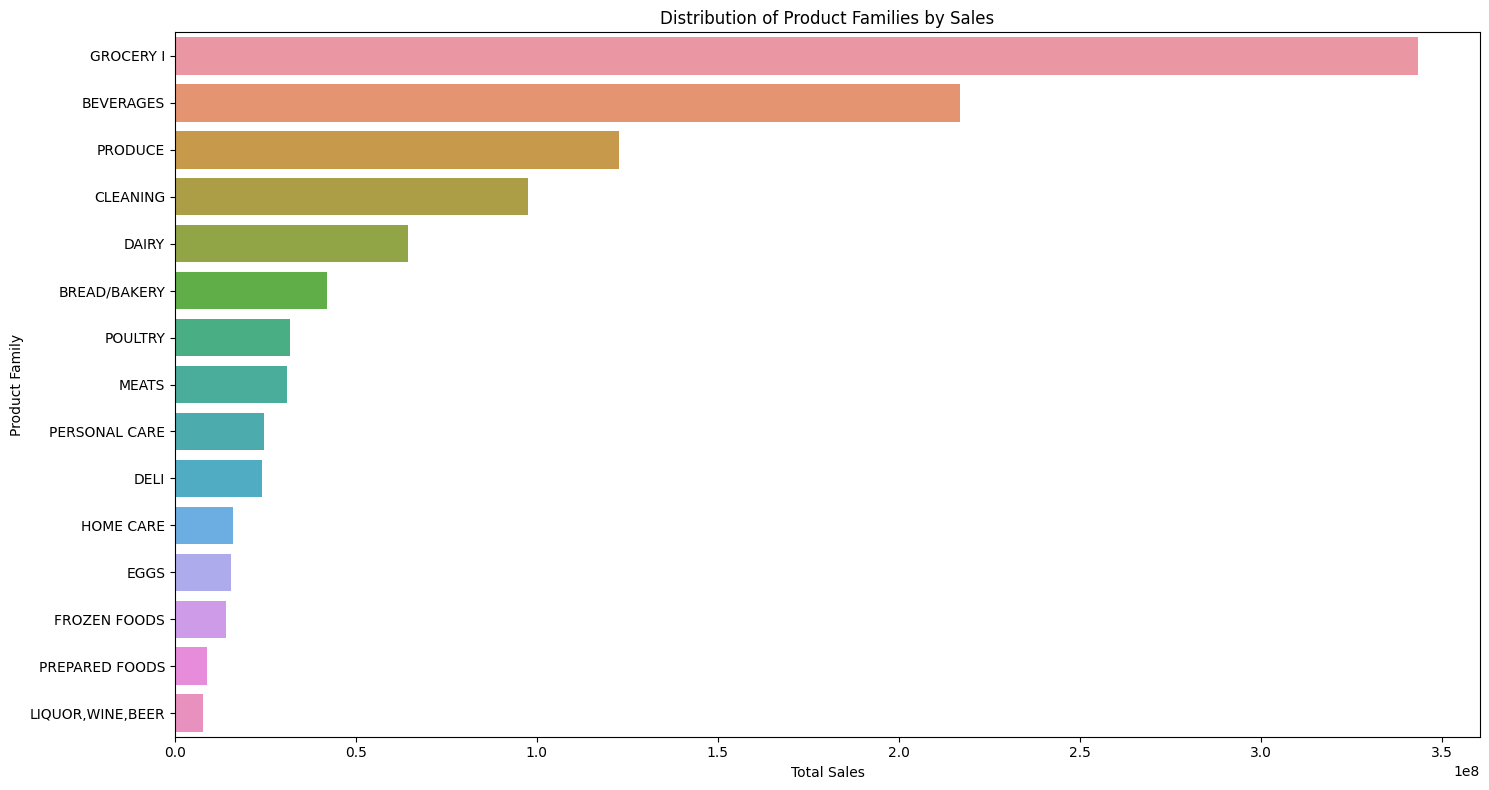

In [54]:
# Group by store and family, then sum the sales
product_sales = (
    train_final.groupby(['family'])['sales'].sum().reset_index()
    .sort_values(by='sales', ascending=False)
)

top_sales = product_sales.head(15)

# Plot a bar chart
plt.figure(figsize=(15, 8))
sns.barplot(
    x='sales', y='family', data=top_sales)
plt.title("Distribution of Product Families by Sales")
plt.xlabel("Total Sales")
plt.ylabel("Product Family")
plt.tight_layout()
plt.show()

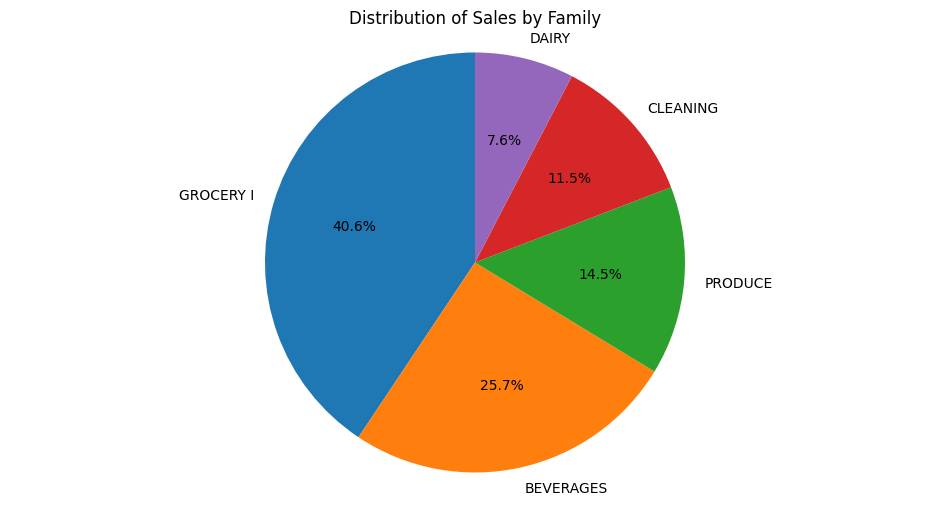

In [71]:
plt.figure(figsize=(12,6))
plt.pie(product_sales.head(5)['sales'].values, 
        labels=product_sales.head(5)['family'].values, 
        autopct='%1.1f%%', startangle=90)

plt.title('Distribution of Sales by Family')
plt.axis('equal')  
plt.show()

## Product specialization of a store

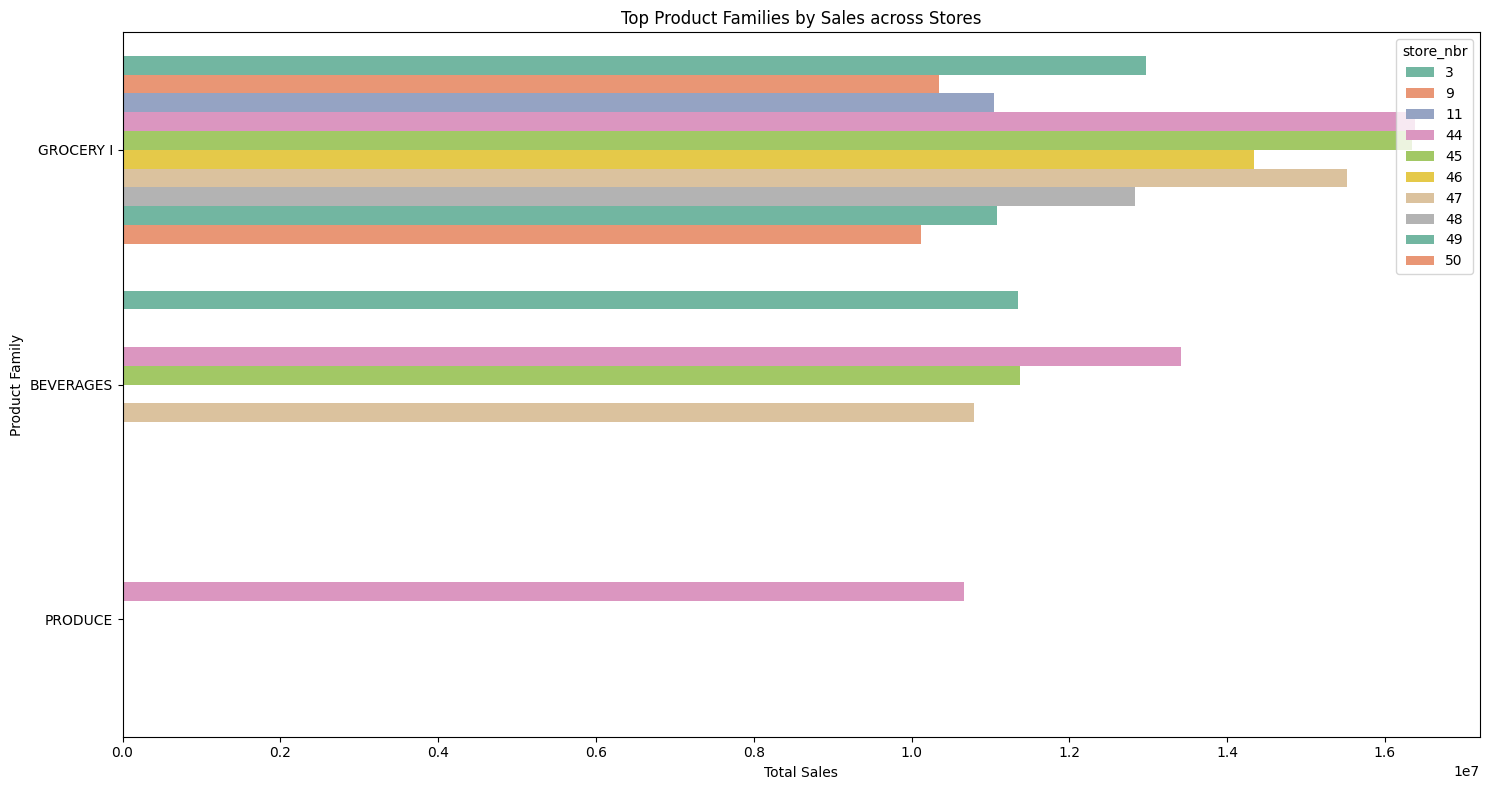

In [53]:
# Group by store and family, then sum the sales
store_family_sales = (
    train_final.groupby(['store_nbr', 'family'])['sales'].sum().reset_index()
    .sort_values(by='sales', ascending=False)
)

top_store_family_sales = store_family_sales.head(15)

# Plot a bar chart
plt.figure(figsize=(15, 8))
sns.barplot(
    x='sales', y='family', hue='store_nbr', data=top_store_family_sales, 
    palette='Set2'
)
plt.title("Top Product Families by Sales across Stores")
plt.xlabel("Total Sales")
plt.ylabel("Product Family")
plt.tight_layout()
plt.show()

## Sales v/s type

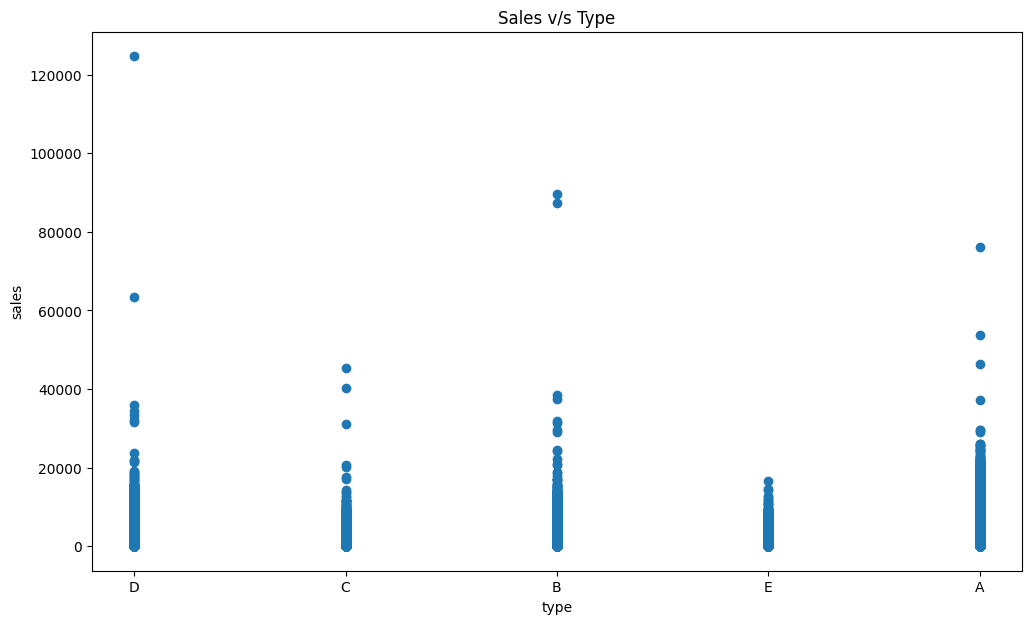

In [59]:
plt.figure(figsize=(12,7))
plt.scatter(train_final['type'], train_final['sales'])
plt.title('Sales v/s Type')
plt.ylabel('sales')
plt.xlabel('type')
plt.show()

## City v/s sales

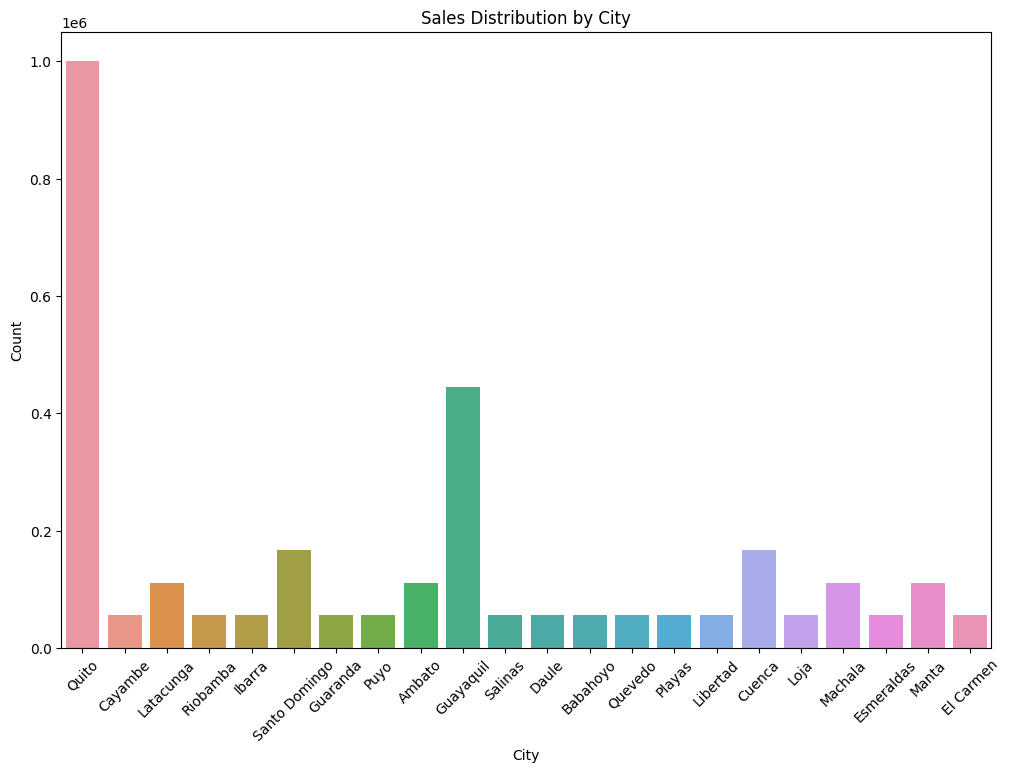

In [76]:
plt.figure(figsize=(12, 8))
sns.countplot(data=train_final, x='city')

plt.xlabel('City')
plt.ylabel('Count')
plt.title('Sales Distribution by City')
plt.xticks(rotation=45)
plt.show()

## Monthly sales trend

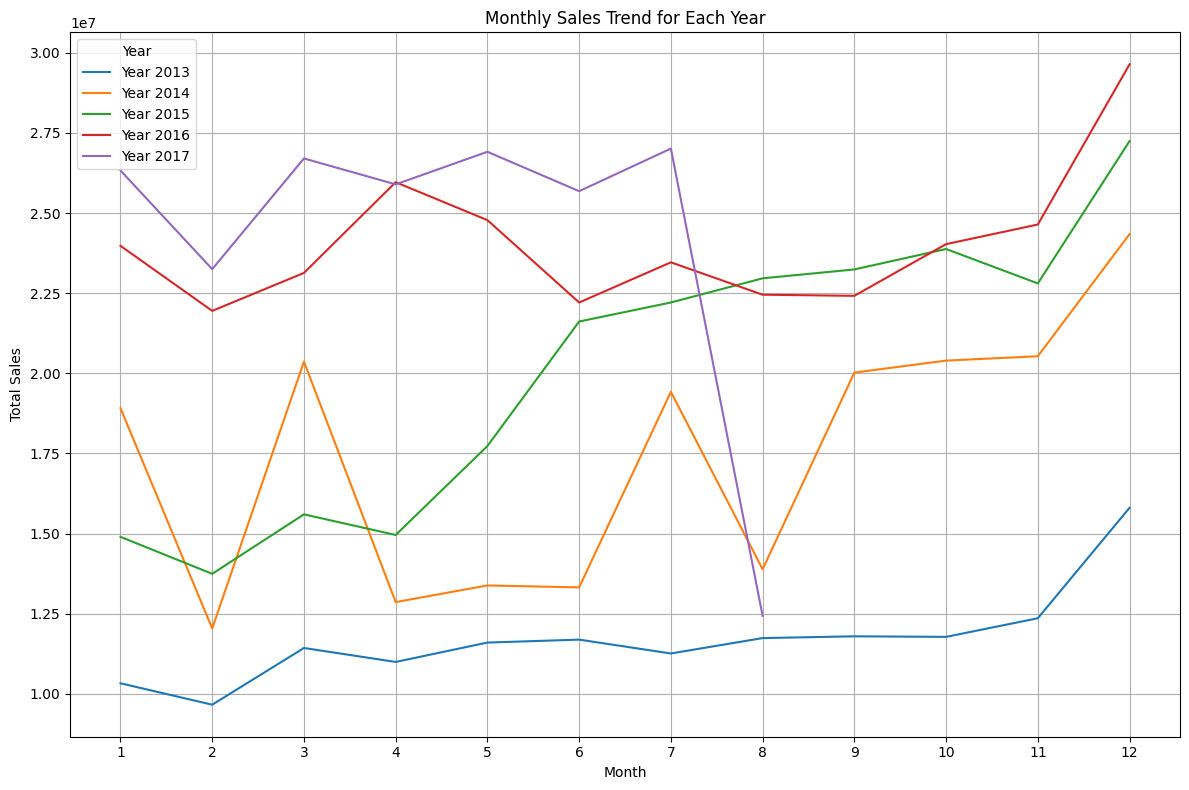

In [87]:
warnings.filterwarnings('ignore')

# Extract year and month
train_final['year'] = train_final['date'].dt.year
train_final['month'] = train_final['date'].dt.month

# Group by year and month, then sum the sales
monthly_sales = train_final.groupby(['year', 'month'])['sales'].sum().reset_index()

# Plot sales trend for each year
plt.figure(figsize=(12, 8))
for year in monthly_sales['year'].unique():
    year_sales = monthly_sales[monthly_sales['year'] == year]
    plt.plot(year_sales['month'], year_sales['sales'], label=f'Year {year}')

# Add labels and legend
plt.title('Monthly Sales Trend for Each Year')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(range(1, 13))
plt.legend(title='Year', loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## Hypothesis Testing

### Does store type affect sales?

>* H0 (>0.05)= The type of stores does not affect store sales. There is no significant difference in store sales between different types of stores.
>* H1 (<0.05)= The type of stores does affect store sales. There is a significant difference in store sales between different types of stores.

In [62]:
# Group sales by store type
store_sales_by_type = train_final.groupby('type')['sales'].apply(list)

# Perform ANOVA test
f_statistic, p_value = stats.f_oneway(*store_sales_by_type)

# Output results
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

# Interpret results
if p_value < 0.05:
    print("Reject the null hypothesis: Sales are significantly affected by store type.")
else:
    print("Fail to reject the null hypothesis: No significant effect of store type on sales.")


F-statistic: 17766.023730362205
P-value: 0.0
Reject the null hypothesis: Sales are significantly affected by store type.


### Does promotion improve sales?

>* Null Hypothesis (H₀): Promotions do not affect sales (the mean sales with and without promotion are the same).
>* Alternative Hypothesis (H₁): Promotions do affect sales (the mean sales with promotion is different from the mean sales without promotion).

In [74]:
correlation, p_value = stats.pearsonr(train_final['onpromotion'], 
                                      train_final['sales'])
print("Pearson correlation coefficient:", correlation)
print("p-value:", p_value)

Pearson correlation coefficient: 0.4279232048121314
p-value: 0.0


>There is significant relationship between sales and onpromotion.

In [75]:
# Separate data into two groups: with promotion and without promotion
with_promotion = train_final[train_final['onpromotion'] > 0]['sales']
without_promotion = train_final[train_final['onpromotion'] == 0]['sales']

# Perform independent t-test
t_stat, p_value = stats.ttest_ind(with_promotion, without_promotion)

# Output results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpret results
if p_value < 0.05:
    print("Reject the null hypothesis: Promotions significantly improve sales.")
else:
    print("Fail to reject the null hypothesis: Promotions do not significantly improve sales.")


T-statistic: 664.1236909096904
P-value: 0.0
Reject the null hypothesis: Promotions significantly improve sales.


# Autocorrelation